In [1]:
#from the docs
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm

In [2]:
#from the docs extra for colab working
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

In [ ]:
from unsloth import FastLanguageModel
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from transformers import BitsAndBytesConfig, pipeline
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
from datasets import Dataset, DatasetDict


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-04 05:28:24 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-04 05:28:24 [__init__.py:239] Automatically detected platform cuda.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import json

def load_data(file_path):
    """Load your essay grading dataset from a JSONL file (one JSON object per line)"""
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f if line.strip()]
    return pd.DataFrame(data)

data = load_data('/content/drive/MyDrive/Unsloth model/formatted_dataset.jsonl')


In [ ]:
def format_instruction(row):
    instruction = f"""You are an expert examiner. Your task is to evaluate a student's answer and give a score from 0 to 4 and a rationale based on a question, a reference answer, and a detailed mark scheme.

Question:
{row['question']}

Reference Answer:
{row['reference_answer']}

Student Answer:
{row['student_answer']}

Marking Scheme (0–4 points):
{json.dumps(row['mark_scheme'], indent=2) if isinstance(row['mark_scheme'], dict) else row['mark_scheme']}

Instructions:
- Grade the student answer on a scale from 0 to 4 based strictly on the mark scheme.
- For each criterion, assess whether it was satisfied.
- Provide a detailed and objective rationale explaining the score and make it related to the question and the answer contextually.
- Always provide a score of 4 even if you face more than 5 points in mark scheme  try to combine everything and give a score of 4 the same goes when less than 4.
- Be concise, specific, and professional in your explanation."""

    response = f"Score: {row['score']}\nRationale: {row['rationale']}"
    return {
        "instruction": instruction.strip(),
        "output": response.strip()
    }

# Apply formatting
formatted_data = data.apply(format_instruction, axis=1).tolist()
dataset = Dataset.from_pandas(pd.DataFrame(formatted_data))

# Split dataset
dataset_split = dataset.train_test_split(test_size=0.1, seed=3407)
test_set = dataset_split['test']
remaining_set = dataset_split['train']

final_split = remaining_set.train_test_split(test_size=0.1111, seed=3407)
train_set = final_split['train']
val_set = final_split['test']

dataset_dict = DatasetDict({
    "train": train_set,
    "validation": val_set,
    "test": test_set
})

print(f"Train set: {len(train_set)} examples")
print(f"Validation set: {len(val_set)} examples")
print(f"Test set: {len(test_set)} examples")


In [ ]:

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    outputs = examples["output"]
    texts = []

    for instruction, output in zip(instructions, outputs):
        text = f"<s>[INST] {instruction} [/INST] {output}</s>"
        texts.append(text)

    return texts

### configurations

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
MAX_SEQ_LENGTH = 2048 
MODEL_NAME = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
dtype = torch.float16
load_in_4bit = True

In [ ]:
# BitsAndBytes 
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
# TEAM members please make sure to load the already quantisized model instead of using bits and bites (faster)
# Load base model
print("Loading base model")
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=load_in_4bit,
    dtype=dtype,
)
base_tokenizer.pad_token = base_tokenizer.eos_token
base_tokenizer.padding_side = "right"

print("Base model loaded")

In [ ]:

finetuned_model, _ = FastLanguageModel.from_pretrained(
    model_name="/content/drive/MyDrive/modelfolder/final_model",
    max_seq_length=MAX_SEQ_LENGTH,
    quantization_config=bnb_config,
)

print("✅ Fine-tuned model loaded")

Loading fine-tuned model...
==((====))==  Unsloth 2025.5.9: Fast Mistral patching. Transformers: 4.52.4. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Will load /content/drive/MyDrive/modelfolder/final_model as a legacy tokenizer.


unsloth/mistral-7b-instruct-v0.2-bnb-4bit does not have a padding token! Will use pad_token = <unk>.


Unsloth 2025.5.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


✅ Fine-tuned model loaded


In [ ]:
def generate_prediction(model, tokenizer, instruction, max_new_tokens=512):
    prompt = f"<s>[INST] {instruction} [/INST]"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the generated part (after [/INST])
    if "[/INST]" in response:
        response = response.split("[/INST]")[1].strip()

    return response


In [ ]:
def extract_score_from_response(response):
    """Extract numerical score from model response"""
    score_patterns = [
        r"Score\s*:\s*(\d+(?:\.\d+)?)",  # Score: 3 or Score:3.5
        r"^(\d+(?:\.\d+)?)",             # Number at start
        r"score\s*is\s*(\d+(?:\.\d+)?)", # score is 3
        r"(\d+(?:\.\d+)?)\s*out\s*of\s*4", # 3 out of 4
        r"(\d+(?:\.\d+)?)\s*/\s*4",      # 3/4
    ]

    for pattern in score_patterns:
        match = re.search(pattern, response, re.IGNORECASE)
        if match:
            try:
                score = float(match.group(1))
                # Ensure score is within valid range (0-4)
                if 0 <= score <= 4:
                    return score
            except ValueError:
                continue

    # If no valid score found, return None
    return None

In [ ]:
predictions = []
true_scores = []
raw_responses = []

FastLanguageModel.for_inference(finetuned_model)

for i, example in enumerate(tqdm(test_set, desc="Generating predictions")):
    try:
        # Generate prediction
        response = generate_prediction(finetuned_model, base_tokenizer, example['instruction'])
        raw_responses.append(response)

        # Extract score
        predicted_score = extract_score_from_response(response)

        if predicted_score is not None:
            predictions.append(predicted_score)
        else:
            # If no score extracted, assign a default (could be 0 or skip)
            predictions.append(0)  # or you could skip this example
            print(f"Warning: Could not extract score from response {i}: {response[:100]}...")


        true_score_match = re.search(r"Score:\s*(\d+(?:\.\d+)?)", example['output'])
        if true_score_match:
            true_scores.append(float(true_score_match.group(1)))
        else:
            print(f"Warning: Could not extract true score from example {i}")
            true_scores.append(0)

    except Exception as e:
        print(f"Error processing example {i}: {str(e)}")
        predictions.append(0)
        true_scores.append(0)

print(f"Processed {len(predictions)} examples")
print(f"Sample predictions: {predictions[:5]}")
print(f"Sample true scores: {true_scores[:5]}")


Running inference on test set...


Generating predictions: 100%|██████████| 355/355 [22:43<00:00,  3.84s/it]

Processed 355 examples
Sample predictions: [3.0, 2.0, 3.0, 3.0, 4.0]
Sample true scores: [3.0, 3.0, 3.0, 3.0, 3.0]


In [ ]:
raw_responses[1]

'Score: 2\nRationale: Defines as distance between peaks (1 & 2). "How long the wave is" hints at spatial period/repeating shape (3). Not fully explicit.'

### regression metrics (MAE, RMSE)

In [ ]:
# Convert to numpy arrays
y_true = np.array(true_scores)
y_pred = np.array(predictions)

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("=" * 50)
print("REGRESSION METRICS")
print("=" * 50)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Additional regression metrics
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Square Error (MSE): {mse:.4f}")

# Calculate correlation
correlation = np.corrcoef(y_true, y_pred)[0, 1]
print(f"Pearson Correlation: {correlation:.4f}")


REGRESSION METRICS
Mean Absolute Error (MAE): 0.2620
Root Mean Square Error (RMSE): 0.5281
Mean Square Error (MSE): 0.2789
Pearson Correlation: 0.9197


### classification metrics (F1 score)

In [ ]:
# For F1 score, we need to treat this as a classification problem
# Round predictions to nearest integer for classification
y_true_class = np.round(y_true).astype(int)
y_pred_class = np.round(y_pred).astype(int)

# Ensure all values are within valid range (0-4)
y_true_class = np.clip(y_true_class, 0, 4)
y_pred_class = np.clip(y_pred_class, 0, 4)

# Calculate F1 scores
f1_macro = f1_score(y_true_class, y_pred_class, average='macro')
f1_micro = f1_score(y_true_class, y_pred_class, average='micro')
f1_weighted = f1_score(y_true_class, y_pred_class, average='weighted')

# Calculate per-class F1 scores
f1_per_class = f1_score(y_true_class, y_pred_class, average=None)

print("\n" + "=" * 50)
print("CLASSIFICATION METRICS")
print("=" * 50)
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

print("\nPer-class F1 Scores:")
for i, f1 in enumerate(f1_per_class):
    print(f"  Score {i}: {f1:.4f}")



CLASSIFICATION METRICS
F1 Score (Macro): 0.7174
F1 Score (Micro): 0.7465
F1 Score (Weighted): 0.7434

Per-class F1 Scores:
  Score 0: 0.7925
  Score 1: 0.7111
  Score 2: 0.5872
  Score 3: 0.8298
  Score 4: 0.6667


### Confustion Metrix/kappa


CONFUSION MATRIX


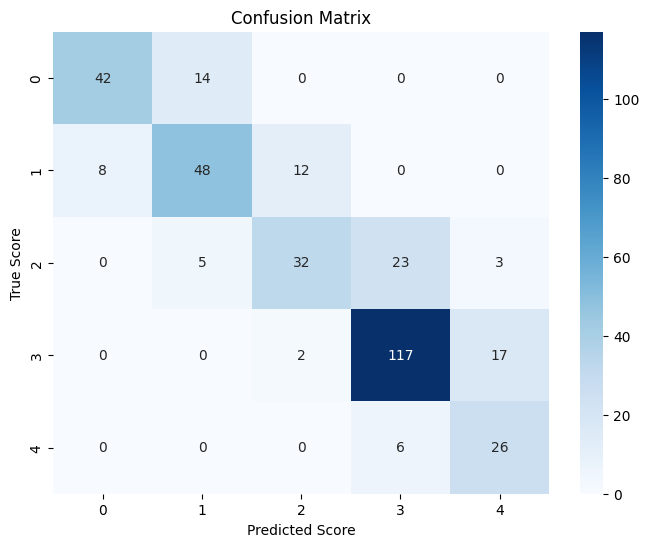


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Score 0       0.84      0.75      0.79        56
     Score 1       0.72      0.71      0.71        68
     Score 2       0.70      0.51      0.59        63
     Score 3       0.80      0.86      0.83       136
     Score 4       0.57      0.81      0.67        32

    accuracy                           0.75       355
   macro avg       0.72      0.73      0.72       355
weighted avg       0.75      0.75      0.74       355


COHEN'S KAPPA
Cohen's Kappa: 0.6617


In [ ]:

import matplotlib.pyplot as plt
# Cell 7: Generate and plot Confusion Matrix
print("\n" + "=" * 50)
print("CONFUSION MATRIX")
print("=" * 50)

conf_matrix = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1, 2, 3, 4])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Score')
plt.ylabel('True Score')
plt.title('Confusion Matrix')
plt.show()

print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true_class, y_pred_class, labels=[0, 1, 2, 3, 4], target_names=[f'Score {i}' for i in range(5)]))

kappa = cohen_kappa_score(y_true_class, y_pred_class)
print("\n" + "=" * 50)
print("COHEN'S KAPPA")
print("=" * 50)
print(f"Cohen's Kappa: {kappa:.4f}")

### ACCURACY METRICS

In [ ]:
exact_accuracy = np.mean(y_true_class == y_pred_class)

# Within-1 accuracy (prediction within 1 point of true score)
within_1_accuracy = np.mean(np.abs(y_true_class - y_pred_class) <= 1)

print("\n" + "=" * 50)
print("ACCURACY METRICS")
print("=" * 50)
print(f"Exact Match Accuracy: {exact_accuracy:.4f}")
print(f"Within-1 Accuracy: {within_1_accuracy:.4f}")


ACCURACY METRICS
Exact Match Accuracy: 0.7465
Within-1 Accuracy: 0.9915


In [ ]:

import matplotlib.pyplot as plt
# Install necessary library if not already installed
try:
    from sentence_transformers import SentenceTransformer, util
except ImportError:
    !pip install -q sentence-transformers
    from sentence_transformers import SentenceTransformer, util

### Calculate Rationale Similarity Metric


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Sentence-BERT model loaded

RATIONALE SIMILARITY METRIC
Calculating embeddings for 355 rationale pairs...
Average Rationale Cosine Similarity: 0.7786


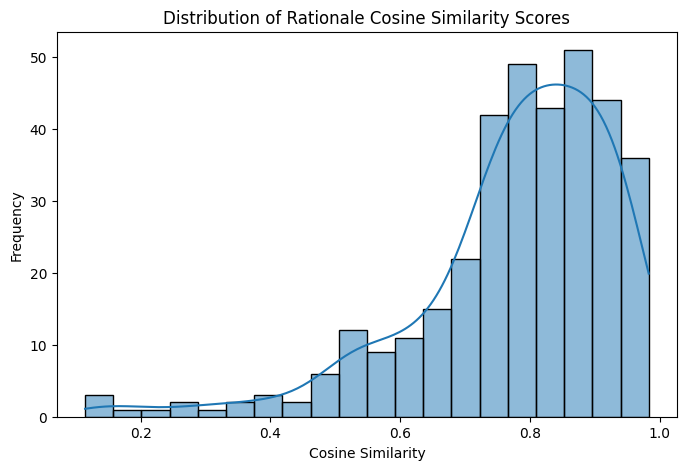


Sample Rationale Comparison:

--- Example 1 (Similarity: 0.7003) ---
True Rationale:
Implies organic (1), only H and C (2), methane example (3).
Predicted Rationale:
Compound made of H and C (2), example given (3). Organic (1) is implied by "compound". Good.

--- Example 2 (Similarity: 0.7511) ---
True Rationale:
Defines as distance (1), from peak to peak (2), and implies shape repeating/length (3).
Predicted Rationale:
Defines as distance between peaks (1 & 2). "How long the wave is" hints at spatial period/repeating shape (3). Not fully explicit.

--- Example 3 (Similarity: 0.9589) ---
True Rationale:
Defines epilepsy as a brain condition (point 1) where the main thing is repeated seizures (point 2). "For no clear reason" implies unprovoked (point 3).
Predicted Rationale:
Defines epilepsy as brain condition (point 1). "For no clear reason" implies unprovoked (partially point 3). "Main thing is repeated seizures" (point 2). Misses optional point 4. Good answer.


In [ ]:

rationale_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Sentence-BERT model loaded")

print("\n" + "=" * 50)
print("RATIONALE SIMILARITY METRIC")
print("=" * 50)

# Extract true and predicted rationales
true_rationales = []
predicted_rationales = []

for example, raw_response in zip(test_set, raw_responses):
    #extract true
    true_rationale_match = re.search(r"Rationale:\s*(.*)", example['output'], re.DOTALL)
    if true_rationale_match:
        true_rationales.append(true_rationale_match.group(1).strip())
    else:
        true_rationales.append("") #empty if none found

    # extract only the rationale without the score
    predicted_rationale_match = re.search(r"Rationale:\s*(.*)", raw_response, re.DOTALL)
    if predicted_rationale_match:
         # did the model genrate any thing after the rationale ? remove it
        predicted_rationale = predicted_rationale_match.group(1).strip()
        if "[/INST]" in predicted_rationale:
             predicted_rationale = predicted_rationale.split("[/INST]")[0].strip()
        predicted_rationales.append(predicted_rationale)
    else:
        predicted_rationales.append("") #empty if none found

#gotta be the same length obvi
if len(true_rationales) != len(predicted_rationales):
    print(f"Warning: Mismatch in the number of true ({len(true_rationales)}) and predicted ({len(predicted_rationales)}) rationales. Cannot calculate similarity.")
else:
    #calculate embidings
    print(f"Calculating embeddings for {len(true_rationales)} rationale pairs...")
    #handle empty strings
    valid_true_rationales = [r for r in true_rationales if r]
    valid_predicted_rationales = [r for r in predicted_rationales if r]

    #create a mapping
    true_indices = [i for i, r in enumerate(true_rationales) if r]
    predicted_indices = [i for i, r in enumerate(predicted_rationales) if r]


    # only compute embeddings if there are non-empty rationales
    if valid_true_rationales and valid_predicted_rationales and true_indices == predicted_indices:
        true_embeddings = rationale_model.encode(valid_true_rationales, convert_to_tensor=True, show_progress_bar=False)
        predicted_embeddings = rationale_model.encode(valid_predicted_rationales, convert_to_tensor=True, show_progress_bar=False)
        #cos simalrirty
        similarity_scores = util.cos_sim(true_embeddings, predicted_embeddings)
        pairwise_similarity = torch.diag(similarity_scores)

        #average
        average_similarity = torch.mean(pairwise_similarity).item()

        print(f"Average Rationale Cosine Similarity: {average_similarity:.4f}")

        #ai generated
        plt.figure(figsize=(8, 5))
        sns.histplot(pairwise_similarity.cpu().numpy(), bins=20, kde=True)
        plt.title('Distribution of Rationale Cosine Similarity Scores')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')
        plt.show()
    else:
         print("Could not calculate rationale similarity due to missing or mismatched rationales.")
         print(f"Number of true rationales found: {len(valid_true_rationales)}")
         print(f"Number of predicted rationales found: {len(valid_predicted_rationales)}")


#sample
print("\nSample Rationale Comparison:")
for i in range(min(3, len(true_rationales))):
    if i < len(pairwise_similarity):
        print(f"\n--- Example {i+1} (Similarity: {pairwise_similarity[i].item():.4f}) ---")
    else:
         print(f"\n--- Example {i+1} (Similarity: N/A - rationale missing) ---")
    print(f"True Rationale:\n{true_rationales[i]}")
    print(f"Predicted Rationale:\n{predicted_rationales[i]}")


In [ ]:


# Function to get user input and generate prediction
def get_user_input_and_predict(model, tokenizer):
    print("\nPlease provide the following information:")

    question = input("Enter the Question: ")
    reference_answer = input("Enter the Reference Answer: ")
    student_answer = input("Enter the Student Answer: ")
    mark_scheme_str = input("Enter the Marking Scheme (can be text or a JSON string representation of a dict): ")

    try:
        mark_scheme = json.loads(mark_scheme_str)
    except json.JSONDecodeError:
        mark_scheme = mark_scheme_str


    user_input_data = {
        'question': question,
        'reference_answer': reference_answer,
        'student_answer': student_answer,
        'mark_scheme': mark_scheme,
# not needed dummy var
        'score': 0,
        'rationale': ""
    }

    # Format the instruction for the model
    instruction = format_instruction(user_input_data)['instruction']

    print("\nGenerating prediction...")
    # Generate the prediction using the fine-tuned model
    prediction_response = generate_prediction(model, tokenizer, instruction)

    print("\n" + "=" * 50)
    print("MODEL PREDICTION")
    print("=" * 50)
    print(prediction_response)
    print("=" * 50)
    predicted_score = extract_score_from_response(prediction_response)
    if predicted_score is not None:
        print(f"Predicted Score: {predicted_score}")
        rationale_parts = prediction_response.split("Rationale:")
        if len(rationale_parts) > 1:
            predicted_rationale = rationale_parts[1].strip()
            if "Score:" in predicted_rationale:
                 predicted_rationale = predicted_rationale.split("Score:")[0].strip()
            print(f"Predicted Rationale:\n{predicted_rationale}")
        else:
             print("Rationale could not be clearly separated from the response.")

    else:
        print("Could not extract a numerical score from the prediction.")

print("\nStarting interactive prediction interface...")
get_user_input_and_predict(finetuned_model, base_tokenizer)



Starting interactive prediction interface...

Please provide the following information:


KeyboardInterrupt: Interrupted by user